In [1]:
# importing required library 

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# setting the size of rows & columns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Reading the Data

In [3]:
# reading the file

ngo_df = pd.read_csv('Country-data.csv')
ngo_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
# renaming few columns name to proper readable & understandable format

ngo_df.rename(columns = {'child_mort':'child_mortality', 'life_expec':'life_expectancy', 'total_fer':'total_fertility', 
                         'gdpp':'GDP'}, inplace=True)

In [5]:
# getting the info about the columns datatype

ngo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          167 non-null    object 
 1   child_mortality  167 non-null    float64
 2   exports          167 non-null    float64
 3   health           167 non-null    float64
 4   imports          167 non-null    float64
 5   income           167 non-null    int64  
 6   inflation        167 non-null    float64
 7   life_expectancy  167 non-null    float64
 8   total_fertility  167 non-null    float64
 9   GDP              167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
# getting the structure of dataframe in rows & columns

ngo_df.shape

(167, 10)

### Missing Value Check

In [7]:
# stats of the missing values in the dataframe

ngo_df.isnull().sum()

country            0
child_mortality    0
exports            0
health             0
imports            0
income             0
inflation          0
life_expectancy    0
total_fertility    0
GDP                0
dtype: int64

### Conversion to actual values

In [8]:
# converting exports, health, imports to absolute values as they were the % of the GDP per capita

ngo_df['exports'] = ngo_df['exports']*ngo_df['GDP']/100
ngo_df['health'] = ngo_df['health']*ngo_df['GDP']/100
ngo_df['imports'] = ngo_df['imports']*ngo_df['GDP']/100

In [9]:
# display of the dataframe

ngo_df.head()

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


### Statistical Description of Data

In [10]:
# describing the statistics of the dataframe ranging from 0 to 100 % along mean,median etc.

ngo_df.describe(percentiles=[0, 0.1, 0.05, 0.25, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99, 1])

,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
0%,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
5%,3.460000,70.468800,26.715920,169.281000,1213.000000,0.183400,55.780000,1.390000,465.900000
10%,4.200000,110.224800,36.502560,211.005600,1524.000000,0.587800,57.820000,1.452000,593.800000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
60%,29.160000,2967.092000,469.736800,2961.560000,14980.000000,6.964000,74.560000,2.670000,7334.000000


### Correlation Matrix plot

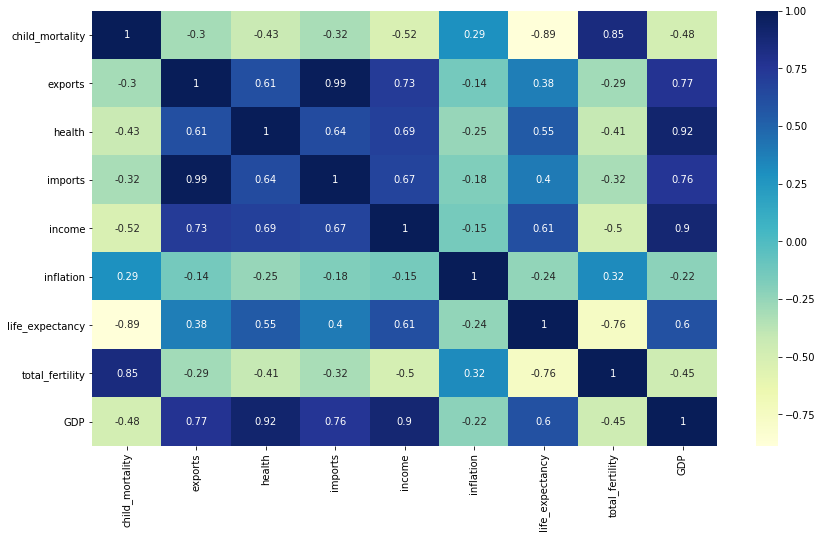

In [11]:
# heatmap of correlation matrix

plt.figure(figsize = (14, 8))
sns.heatmap(ngo_df.corr(), annot=True, cmap='YlGnBu')
plt.show()

### Conclusion
- GDP is highly correlated to health, income, exports, imports.
- imports & exports are highly correlated to each other.
- child mortality & total fertility are also highly correlated to each other.

In [12]:
# displaying the dataframe sorted according to child_mortality in desc & income, gdp in asc.

# ngo_df.sort_values(['child_mortality', 'income', 'GDP'], ascending=(False, True, True)).head()

### Bivariate Analysis of Variables

In [13]:
# number of countries(in %) distributions in child mortality range  

bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270]
# labels = [(0-30), (30-60), (60-90), (90-120), (120-150), (150-180), (180-210), (210-240)]
child_mortality_rate = pd.cut(ngo_df['child_mortality'], bins, right=False, include_lowest=True).value_counts(normalize=True)*100
child_mortality_rate = pd.DataFrame(child_mortality_rate)
child_mortality_rate = child_mortality_rate.reset_index()
child_mortality_rate = child_mortality_rate.rename(columns={'index':'Child_mortality Range', 'child_mortality':'Rate(in %)'})
child_mortality_rate

,Child_mortality Range,Rate(in %)
0,"[0, 30)",61.077844
1,"[30, 60)",13.173653
2,"[60, 90)",11.377246
3,"[90, 120)",10.179641
4,"[120, 150)",2.395210
5,"[150, 180)",1.197605
6,"[180, 210)",0.598802
7,"[240, 270)",0.000000
8,"[210, 240)",0.000000


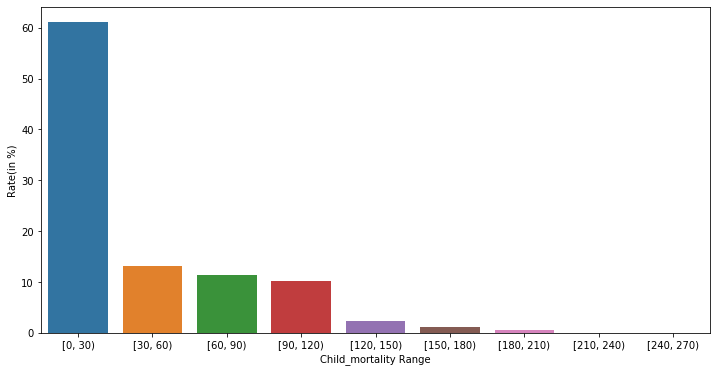

In [14]:
# bar plot of child mortality range

plt.figure(figsize=(12,6))
sns.barplot(x='Child_mortality Range', y='Rate(in %)', data=child_mortality_rate)
plt.show()

- Around the 61% of the countries have child mortality in the range of o-30(excluding)
- Around 13% of countries have child mortality in range greater than 120.

In [15]:
# plotting income range distributions of countries(in %)
# bins = [0, 2500, 5000, 10000, 15000, 30000, 60000, ]

income_range = pd.cut(ngo_df.income, bins=np.linspace(0, 130000, num=14),right=False, include_lowest=True).value_counts(normalize=True)*100
income_range = pd.DataFrame(income_range)
income_range = income_range.reset_index()
income_range = income_range.rename(columns={'index':'Income Range', 'income':'No. of Countries(in %)'})
income_range

,Income Range,No. of Countries(in %)
0,"[0.0, 10000.0)",50.299401
1,"[10000.0, 20000.0)",19.760479
2,"[20000.0, 30000.0)",10.778443
3,"[40000.0, 50000.0)",7.784431
4,"[30000.0, 40000.0)",6.586826
5,"[70000.0, 80000.0)",1.197605
6,"[50000.0, 60000.0)",1.197605
7,"[120000.0, 130000.0)",0.598802
8,"[90000.0, 100000.0)",0.598802
9,"[80000.0, 90000.0)",0.598802


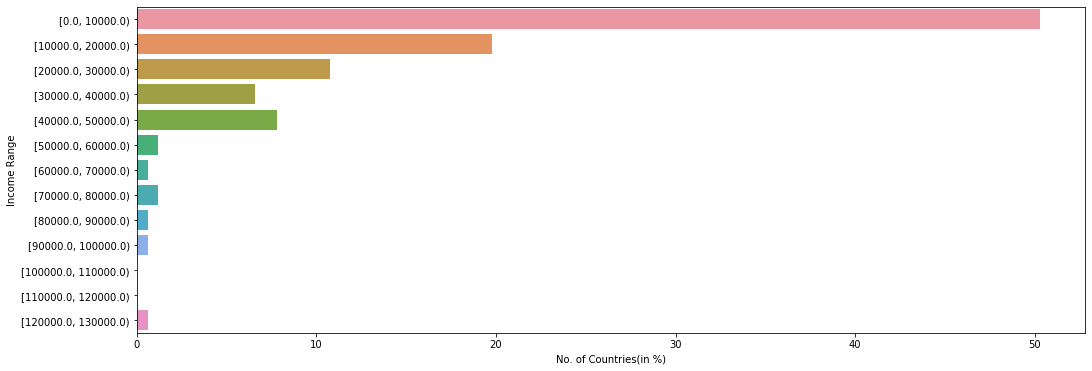

In [16]:
# plotting the income range distributions

plt.figure(figsize=(17,6))
sns.barplot(y='Income Range', x='No. of Countries(in %)', data=income_range)
plt.show()

- Around 50% of countries have income within the 10k.
- Aprox 3.7% of countries have income in range greater than 60k
- Aprox 47% of countries lies in range between 10k to 60k(excluding)

In [17]:
# top50_less_income_countries = ngo_df[ngo_df['income']==125000].head()
# top50_less_income_countries.shape

In [18]:
# # income plot of all countries
# plt.figure(figsize=(10, 10))
# sns.barplot(y='country', x='income', data=top50_less_income_countries, order=top50_less_income_countries.sort_values('income').country)
# plt.show()

In [19]:
# # health plot of all countries
# plt.figure(figsize=(10,44))
# sns.barplot(y='country', x='health', data=ngo_df, order=ngo_df.sort_values('health').country)
# plt.show()

In [20]:
# # gdp plot of all countries
# plt.figure(figsize=(10,44))
# sns.barplot(y='country', x='gdpp', data=ngo_df, order=ngo_df.sort_values('gdpp').country)
# plt.show()

In [21]:
# # child_mort plot of all countries
# plt.figure(figsize=(10,44))
# sns.barplot(y='country', x='child_mort', data=ngo_df, order=ngo_df.sort_values('child_mort').country)
# plt.show()

In [22]:
# plotting gdp range distributions of countries

gdp_range = pd.cut(ngo_df.GDP, bins=np.linspace(0, 110000, num=14),right=False, include_lowest=True).value_counts(normalize=True)*100
gdp_range = pd.DataFrame(gdp_range)
gdp_range = gdp_range.reset_index()
gdp_range = gdp_range.rename(columns={'index':'GDP Range', 'GDP':'No. of Countries(in %)'})
gdp_range

,GDP Range,No. of Countries(in %)
0,"[0.0, 8461.538)",63.473054
1,"[8461.538, 16923.077)",13.173653
2,"[42307.692, 50769.231)",5.389222
3,"[16923.077, 25384.615)",5.389222
4,"[33846.154, 42307.692)",4.790419
5,"[25384.615, 33846.154)",3.592814
6,"[50769.231, 59230.769)",1.796407
7,"[67692.308, 76153.846)",1.197605
8,"[101538.462, 110000.0)",0.598802
9,"[84615.385, 93076.923)",0.598802


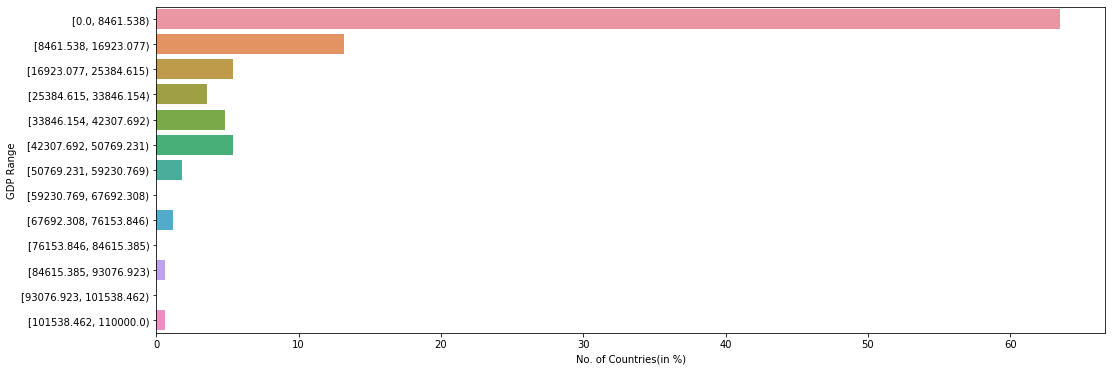

In [23]:
# plotting gdp range distributions

plt.figure(figsize=(17,6))
sns.barplot(y='GDP Range', x='No. of Countries(in %)', data=gdp_range)
plt.show()

- Around 63% of countries have their gdp within the range 9k
- Approx 4.2% of countries have their gdp greater than 50k
- Approx 33% of countries have gdp in between the range 9k & 50k

In [24]:
# plotting inflation rate distribution among various countries

inflation_range = pd.cut(ngo_df.inflation, bins=np.linspace(-10, 110, num=14),right=False, include_lowest=True).value_counts(normalize=True)*100
inflation_range = pd.DataFrame(inflation_range)
inflation_range = inflation_range.reset_index()
inflation_range = inflation_range.rename(columns={'index':'Inflation Range', 'inflation':'No. of Countries(in %)'})
inflation_range

,Inflation Range,No. of Countries(in %)
0,"[-0.769, 8.462)",63.473054
1,"[8.462, 17.692)",24.550898
2,"[17.692, 26.923)",6.586826
3,"[-10.0, -0.769)",3.592814
4,"[100.769, 110.0)",0.598802
5,"[45.385, 54.615)",0.598802
6,"[36.154, 45.385)",0.598802
7,"[91.538, 100.769)",0.000000
8,"[82.308, 91.538)",0.000000
9,"[73.077, 82.308)",0.000000


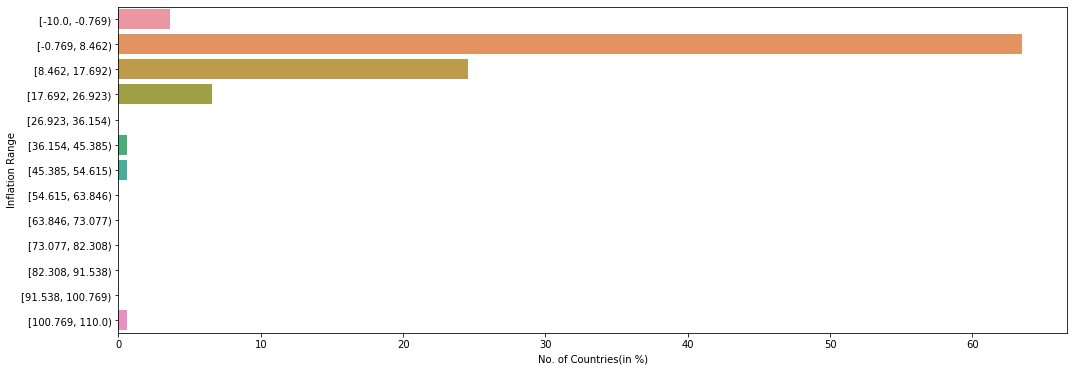

In [25]:
# plotting the inflation range distributions

plt.figure(figsize=(17,6))
sns.barplot(y='Inflation Range', x='No. of Countries(in %)', data=inflation_range)
plt.show()

- Around 3.6% of countries have inflation rate in negative in range -10 to -0.77.
- Around 63% countries have inflation rate in between -0.77 to 8.4
- Around 24% countries have inflation rate in between 8.4 to 17.7
- Around 8% countries have inflation rate greater than 17.7

In [26]:
# plotting life_expectancy vs no of countries(in %)

lifexpectancy_range = pd.cut(ngo_df.life_expectancy, bins=np.linspace(0, 95, num=12),right=False, include_lowest=True).value_counts(normalize=True)*100
lifexpectancy_range = pd.DataFrame(lifexpectancy_range)
lifexpectancy_range = lifexpectancy_range.reset_index()
lifexpectancy_range = lifexpectancy_range.rename(columns={'index':'Life Expectancy Range', 'life_expectancy':'No. of Countries(in %)'})
lifexpectancy_range

,Life Expectancy Range,No. of Countries(in %)
0,"[69.091, 77.727)",40.718563
1,"[77.727, 86.364)",22.754491
2,"[60.455, 69.091)",20.958084
3,"[51.818, 60.455)",13.772455
4,"[43.182, 51.818)",1.197605
5,"[25.909, 34.545)",0.598802
6,"[86.364, 95.0)",0.000000
7,"[34.545, 43.182)",0.000000
8,"[17.273, 25.909)",0.000000
9,"[8.636, 17.273)",0.000000


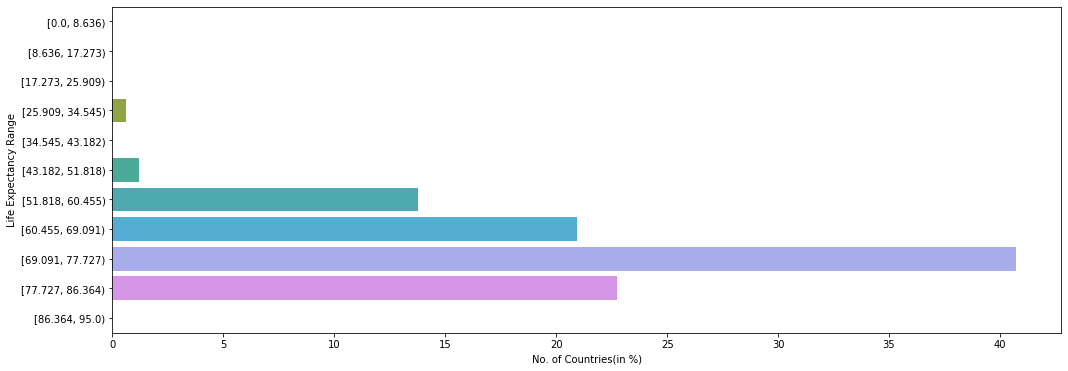

In [27]:
# plotting life expextancy distribution

plt.figure(figsize=(17,6))
sns.barplot(y='Life Expectancy Range', x='No. of Countries(in %)', data=lifexpectancy_range)
plt.show()

- Around 40% countries have life expectancy of 77 years.
- Around 23% countries have life expectancy of 86 years.
- Around 21% countries have life expectancy of 69 years.
- Around 15% countries have life expectancy of 60 years.

In [28]:
# total_fer distribution in among various countries(in %)

totalFert_range = pd.cut(ngo_df.total_fertility, bins=np.linspace(0, 10, num=12),right=False, include_lowest=True).value_counts(normalize=True)*100
totalFert_range = pd.DataFrame(totalFert_range)
totalFert_range = totalFert_range.reset_index()
totalFert_range = totalFert_range.rename(columns={'index':'Total Fertility Range', 'total_fertility':'No. of Countries(in %)'})
totalFert_range

,Total Fertility Range,No. of Countries(in %)
0,"[1.818, 2.727)",35.329341
1,"[0.909, 1.818)",25.748503
2,"[4.545, 5.455)",13.173653
3,"[2.727, 3.636)",11.976048
4,"[3.636, 4.545)",5.988024
5,"[5.455, 6.364)",5.389222
6,"[6.364, 7.273)",1.796407
7,"[7.273, 8.182)",0.598802
8,"[9.091, 10.0)",0.000000
9,"[8.182, 9.091)",0.000000


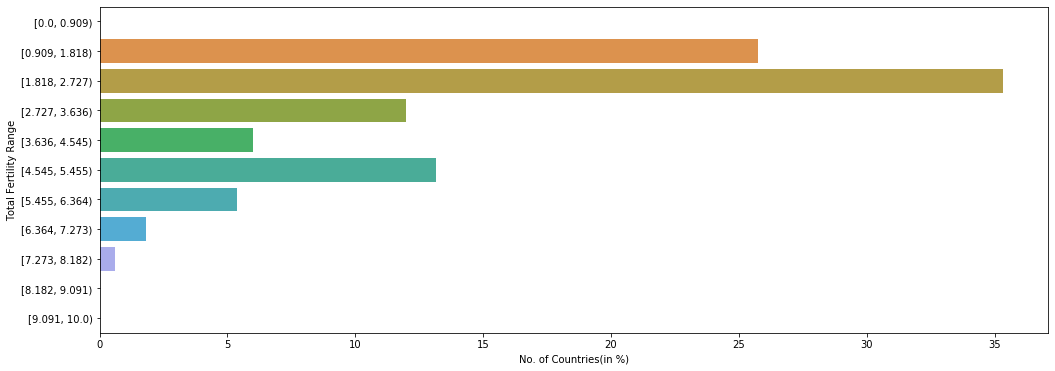

In [29]:
# plotting of total fertility range

plt.figure(figsize=(17,6))
sns.barplot(y='Total Fertility Range', x='No. of Countries(in %)', data=totalFert_range)
plt.show()

- Around 26% countries of have total fertility are within 1.8.
- Around 35% countries have total fertility are in range 1.8 to 2.7.
- Around 12% countries have total fertility in range of 2.7 to 3.6.
- Around 19.7% countries have total fertility in range of 3.6 to 5.5.

In [30]:
# plt.boxplot(x='income', data=ngo_df)
# plt.show()

In [31]:
# plt.boxplot(x='GDP', data=ngo_df)
# plt.show()

In [32]:
# plt.boxplot(x='child_mortality', data=ngo_df)
# plt.show()

### Outlier Detection

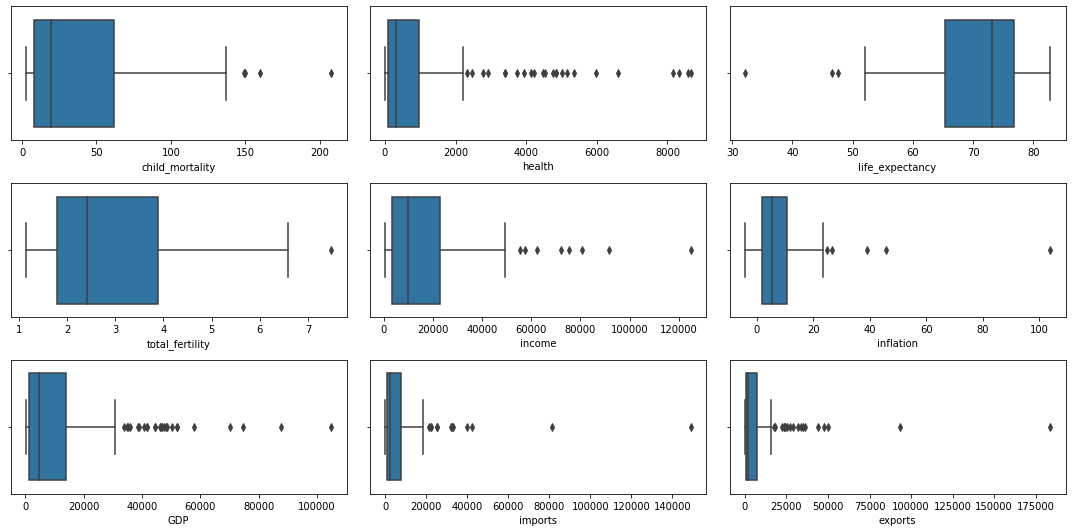

In [33]:
# outlier analysis using boxplot for child_mortality,health,life_expectancy,total_fertility,income,inflation,gdp,imports,exports

fig, axs = plt.subplots(3,3, figsize = (15,7.5))
plt1 = sns.boxplot(ngo_df['child_mortality'], ax = axs[0,0])
plt2 = sns.boxplot(ngo_df['health'], ax = axs[0,1])
plt3 = sns.boxplot(ngo_df['life_expectancy'], ax = axs[0,2])
plt4 = sns.boxplot(ngo_df['total_fertility'], ax = axs[1,0])
plt5 = sns.boxplot(ngo_df['income'], ax = axs[1,1])
plt6 = sns.boxplot(ngo_df['inflation'], ax = axs[1,2])
plt7 = sns.boxplot(ngo_df['GDP'], ax = axs[2,0])
plt8 = sns.boxplot(ngo_df['imports'], ax = axs[2,1])
plt9 = sns.boxplot(ngo_df['exports'], ax = axs[2,2])
plt.tight_layout()

In [34]:
# As we can see there are a number of outliers in the data.

# Keeping in mind we need to identify backward countries based on socio economic and health factors.
# We will cap the outliers to values accordingly for analysis.

# percentiles = ngo_df['child_mort'].quantile([0.05,0.95]).values
# ngo_df['child_mort'][ngo_df['child_mort'] <= percentiles[0]] = percentiles[0]
# # ngo_df['child_mort'][ngo_df['child_mort'] >= percentiles[1]] = percentiles[1]

# capping the outliers of health column
percentiles = ngo_df['health'].quantile([0.05,0.95]).values
ngo_df['health'][ngo_df['health'] <= percentiles[0]] = percentiles[0]
ngo_df['health'][ngo_df['health'] >= percentiles[1]] = percentiles[1]

# capping the outliers of life_expectancy 
percentiles = ngo_df['life_expectancy'].quantile([0.05,0.95]).values
ngo_df['life_expectancy'][ngo_df['life_expectancy'] <= percentiles[0]] = percentiles[0]
ngo_df['life_expectancy'][ngo_df['life_expectancy'] >= percentiles[1]] = percentiles[1]

# capping the outliers of total_fertility
percentiles = ngo_df['total_fertility'].quantile([0.05,0.95]).values
ngo_df['total_fertility'][ngo_df['total_fertility'] <= percentiles[0]] = percentiles[0]
ngo_df['total_fertility'][ngo_df['total_fertility'] >= percentiles[1]] = percentiles[1]

# capping the outliers of income
percentiles = ngo_df['income'].quantile([0.05,0.95]).values
# ngo_df['income'][ngo_df['income'] <= percentiles[0]] = percentiles[0]
ngo_df['income'][ngo_df['income'] >= percentiles[1]] = percentiles[1]

# capping the outliers of inflation
percentiles = ngo_df['inflation'].quantile([0.05,0.95]).values
ngo_df['inflation'][ngo_df['inflation'] <= percentiles[0]] = percentiles[0]
ngo_df['inflation'][ngo_df['inflation'] >= percentiles[1]] = percentiles[1]

# capping the value of outliers of gdp
percentiles = ngo_df['GDP'].quantile([0.05,0.95]).values
# ngo_df['gdpp'][ngo_df['gdpp'] <= percentiles[0]] = percentiles[0]
ngo_df['GDP'][ngo_df['GDP'] >= percentiles[1]] = percentiles[1]

# capping the value of imports
percentiles = ngo_df['imports'].quantile([0.05,0.95]).values
ngo_df['imports'][ngo_df['imports'] <= percentiles[0]] = percentiles[0]
ngo_df['imports'][ngo_df['imports'] >= percentiles[1]] = percentiles[1]

# capping the value of exports
percentiles = ngo_df['exports'].quantile([0.05,0.95]).values
ngo_df['exports'][ngo_df['exports'] <= percentiles[0]] = percentiles[0]
ngo_df['exports'][ngo_df['exports'] >= percentiles[1]] = percentiles[1]

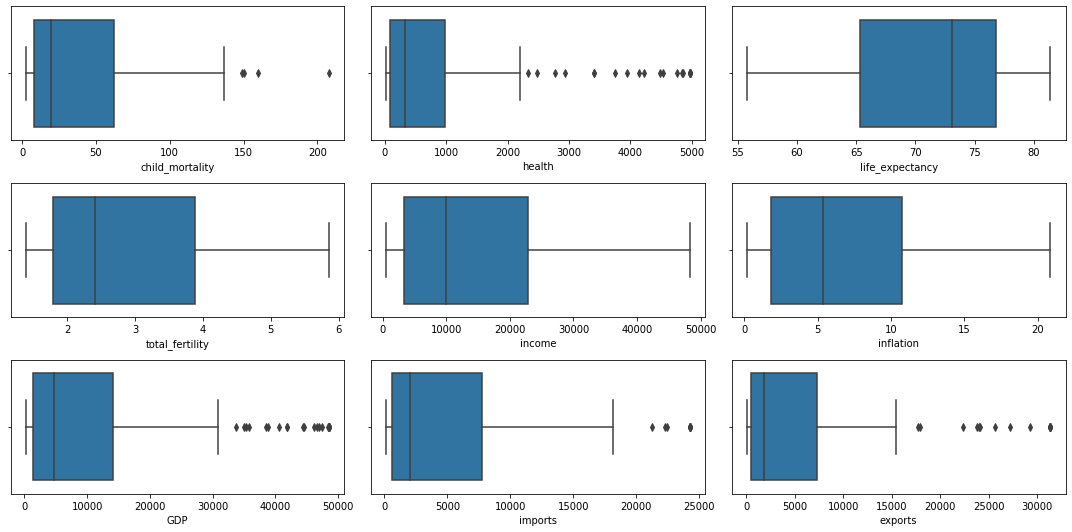

In [35]:
# plotting of variable after treatment of outliers

fig, axs = plt.subplots(3,3, figsize = (15,7.5))
plt1 = sns.boxplot(ngo_df['child_mortality'], ax = axs[0,0])
plt2 = sns.boxplot(ngo_df['health'], ax = axs[0,1])
plt3 = sns.boxplot(ngo_df['life_expectancy'], ax = axs[0,2])
plt4 = sns.boxplot(ngo_df['total_fertility'], ax = axs[1,0])
plt5 = sns.boxplot(ngo_df['income'], ax = axs[1,1])
plt6 = sns.boxplot(ngo_df['inflation'], ax = axs[1,2])
plt7 = sns.boxplot(ngo_df['GDP'], ax = axs[2,0])
plt8 = sns.boxplot(ngo_df['imports'], ax = axs[2,1])
plt9 = sns.boxplot(ngo_df['exports'], ax = axs[2,2])

plt.tight_layout()

### Hopkins Score  Test

In [36]:
# function to calculate hopkins test score

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [37]:
# hoplins test score of the dataframe 

hopkins(ngo_df[['child_mortality','exports','health','imports','income','inflation','life_expectancy','total_fertility','GDP']])

0.9000657444040351

### Data Preprocessing

In [38]:
# scaling the variables

column_list = ['child_mortality','exports','health','imports','income','inflation','life_expectancy','total_fertility','GDP']
scaler = StandardScaler()
scaled_df = scaler.fit_transform(ngo_df[column_list])
scaled_df.shape

(167, 9)

In [39]:
# converting the scaled_df to dataframe as after scaling we get numpy array 

scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns = column_list
scaled_df.head()

,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP
0,1.291532,-0.668039,-0.629778,-0.733291,-0.958349,0.387667,-1.825310,2.020718,-0.757362
1,-0.538949,-0.542389,-0.473807,-0.472674,-0.394006,-0.404004,0.682454,-0.887331,-0.523321
2,-0.272833,-0.476048,-0.530344,-0.560668,-0.192552,1.452825,0.707406,-0.022587,-0.498838
3,2.007808,-0.419165,-0.589272,-0.543598,-0.667360,2.215708,-1.338729,2.049310,-0.560376
4,-0.695634,-0.027297,-0.150953,0.306143,0.227992,-0.891802,0.744836,-0.552591,0.013312


### Silhouette Analysis

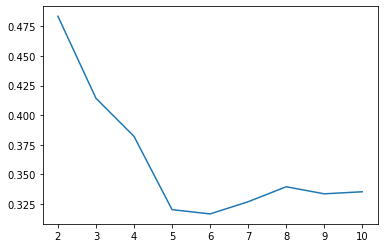

In [40]:
# finding optimal value of k using silhouette score


silhette_Score = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k).fit(scaled_df)
    silhette_Score.append([k, silhouette_score(scaled_df, kmeans.labels_)])
    
plt.plot(pd.DataFrame(silhette_Score)[0], pd.DataFrame(silhette_Score)[1])

### Elbow Curve 

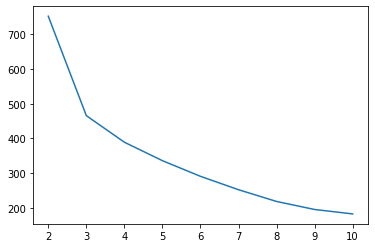

In [41]:
# elbow curve

ssd = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k).fit(scaled_df)
    ssd.append([k, kmeans.inertia_])
    
plt.plot(pd.DataFrame(ssd)[0], pd.DataFrame(ssd)[1])

### Model Building using KMeans

In [42]:
# using value of k=4

kmeans = KMeans(n_clusters=4, random_state=101)
kmeans.fit(scaled_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=101, tol=0.0001, verbose=0)

In [43]:
# converting the obtained cluster into dataframe

cluster_id = pd.DataFrame(kmeans.labels_, columns=['cluster_id'])

In [44]:
cluster_id.head()

,cluster_id
0,3
1,0
2,0
3,3
4,0


In [45]:
# copying the original dataframe to new variable cluster_df

cluster_df = ngo_df.copy()

In [46]:
# concatenating the cluster_df with the obtained cluster id

cluster_df = pd.concat([cluster_df, cluster_id], axis =1)

In [47]:
# displaying the dataframe with the obtained clusterid

cluster_df.head()

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP,cluster_id
0,Afghanistan,90.2,70.4688,41.9174,248.297,1610.0,9.44,56.2,5.820,553,3
1,Albania,16.6,1145.2000,267.8950,1987.740,9930.0,4.49,76.3,1.650,4090,0
2,Algeria,27.3,1712.6400,185.9820,1400.440,12900.0,16.10,76.5,2.890,4460,0
3,Angola,119.0,2199.1900,100.6050,1514.370,5900.0,20.87,60.1,5.861,3530,3
4,Antigua and Barbuda,10.3,5551.0000,735.6600,7185.800,19100.0,1.44,76.8,2.130,12200,0


### Counts in Cluster

In [48]:
# distribution of countries in the obtained cluster obtained

cluster_df.cluster_id.value_counts()

0    76
3    48
2    26
1    17
Name: cluster_id, dtype: int64

### Visualization of Clusters

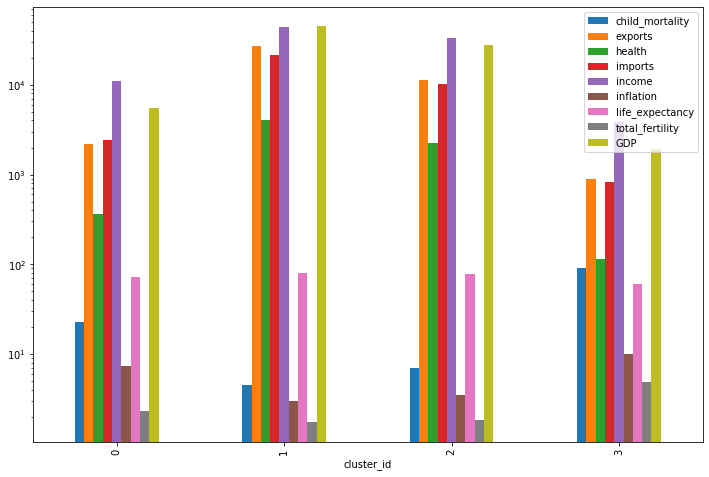

In [49]:
# visualization of clusters obtained, among the variable present in the dataframe

profile = cluster_df.groupby('cluster_id').mean()
profile.plot(kind='bar', figsize=(12,8))
plt.yscale('log')
plt.show()

### Cluster visualization in terms of income & child mortality

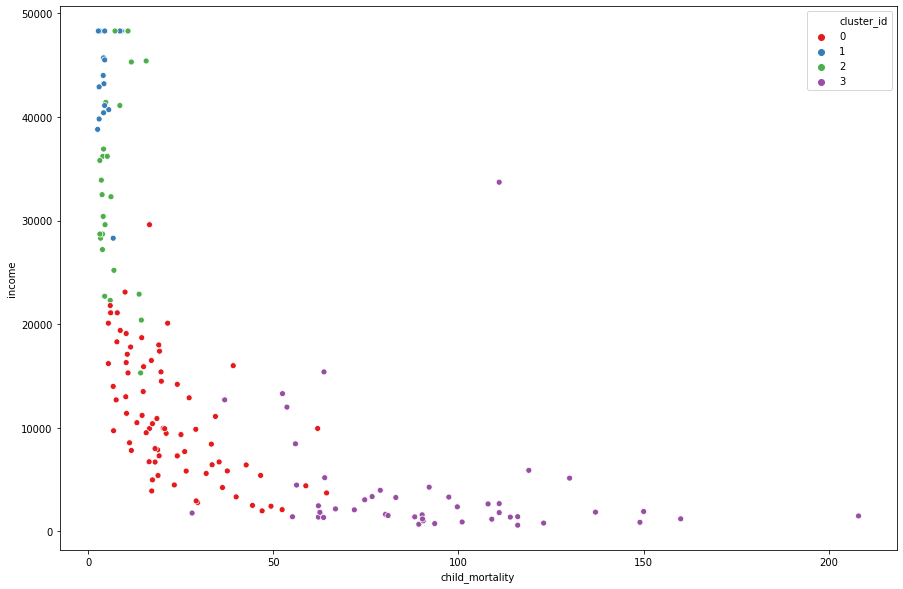

In [50]:
# plotting scatter plot of clusters obtained in kmeans between variables income & child mortality

plt.figure(figsize=(15,10))
sns.scatterplot(x='child_mortality', y='income', data=cluster_df, hue='cluster_id', palette='Set1')
plt.show()

### Cluster Visualization in terms of GDP & Child Mortality

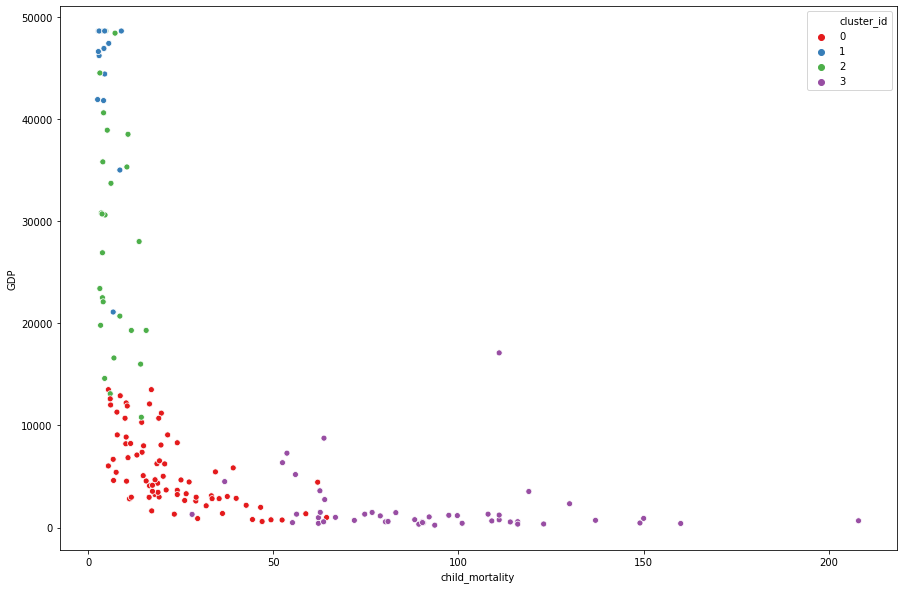

In [51]:
# plotting scatter plot of cluster obtained in kmeans between variables gdp & child mortality

plt.figure(figsize=(15,10))
sns.scatterplot(x='child_mortality', y='GDP', data=cluster_df, hue='cluster_id', palette='Set1')
plt.show()

- From the above two plots between child mortality GDP and income we can find cluster-3 is in urgent need of aid.

### Data Inspection of Each Cluster

In [52]:
# displaying few rows of cluster = 0

cluster_df[cluster_df['cluster_id'] == 0].sort_values(by = ['child_mortality', 'income', 'GDP'], 
                                                          ascending = [False, True, True]).head(5)

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP,cluster_id
107,Myanmar,64.4,70.4688,26.71592,169.281,3720.0,7.04,66.8,2.41,988,0
154,Turkmenistan,62.0,3387.7200,111.00000,1975.800,9940.0,2.31,67.9,2.83,4440,0
69,India,58.8,305.1000,54.67500,365.850,4410.0,8.98,66.2,2.60,1350,0
146,Tajikistan,52.4,109.9620,44.13240,432.468,2110.0,12.50,69.6,3.51,738,0
12,Bangladesh,49.4,121.2800,26.71592,169.281,2440.0,7.14,70.4,2.33,758,0


In [53]:
# displaying few rows of cluster = 1

cluster_df[cluster_df['cluster_id']==1].sort_values(by = ['child_mortality', 'income', 'GDP'], 
                                                          ascending = [False, True, True]).head(5)

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP,cluster_id
123,Qatar,9.0,31385.1,1272.430,16731.40,48290.0,6.98,79.5,2.07,48610,1
157,United Arab Emirates,8.6,27195.0,1281.000,22260.00,48290.0,12.50,76.5,1.87,35000,1
98,Malta,6.8,31385.1,1825.150,24241.56,28300.0,3.83,80.3,1.39,21100,1
29,Canada,5.6,13793.4,4966.701,14694.00,40700.0,2.87,81.3,1.63,47400,1
15,Belgium,4.5,31385.1,4750.800,24241.56,41100.0,1.88,80.0,1.86,44400,1


In [54]:
# displaying few rows of cluster = 2

cluster_df[cluster_df['cluster_id'] == 2].sort_values(by = ['child_mortality', 'income', 'GDP'], 
                                                          ascending = [False, True, True]).head(5)

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP,cluster_id
128,Saudi Arabia,15.7,9572.8,827.97,6369.0,45400.0,17.2000,75.1,2.96,19300,2
131,Seychelles,14.4,10130.4,367.20,11664.0,20400.0,0.1834,73.4,2.17,10800,2
13,Barbados,14.2,6320.0,1275.20,7792.0,15300.0,0.3210,76.7,1.78,16000,2
10,Bahamas,13.8,9800.0,2209.20,12236.0,22900.0,0.1834,73.8,1.86,28000,2
115,Oman,11.7,12680.1,534.61,7951.6,45300.0,15.6000,76.1,2.90,19300,2


In [55]:
# displaying few rows of cluster = 3

cluster_df[cluster_df['cluster_id'] == 3].sort_values(by = ['child_mortality', 'income', 'GDP'], 
                                                          ascending = [False, True, True]).head(5)

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP,cluster_id
66,Haiti,208.0,101.2860,45.74420,428.314,1500.0,5.45,55.78,3.330,662,3
132,Sierra Leone,160.0,70.4688,52.26900,169.281,1220.0,17.20,55.78,5.200,399,3
32,Chad,150.0,330.0960,40.63410,390.195,1930.0,6.39,56.50,5.861,897,3
31,Central African Republic,149.0,70.4688,26.71592,169.281,888.0,2.01,55.78,5.210,446,3
97,Mali,137.0,161.4240,35.25840,248.508,1870.0,4.37,59.50,5.861,708,3


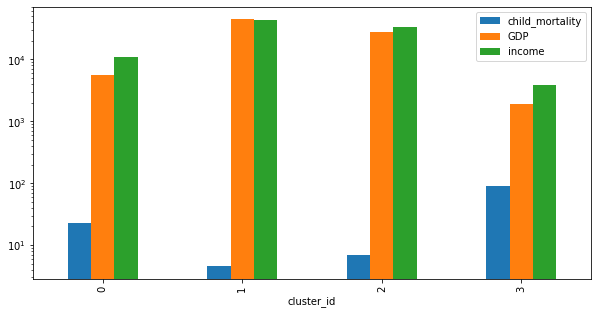

In [56]:
# cluster profiling interms of child mortality, cluster id, gdp, income

profile = cluster_df[['cluster_id', 'child_mortality', 'GDP', 'income']].groupby('cluster_id').mean()
profile.plot(kind='bar', figsize=(10,5))
plt.yscale('log')
plt.show()

In [57]:
# statistical description of the 4 clusters formed using KMeans

KM_Cluster = cluster_df[['cluster_id', 'child_mortality', 'GDP', 'income']].groupby('cluster_id').describe()
KM_Cluster.transpose()

cluster_id                        0             1             2             3
child_mortality count     76.000000     17.000000     26.000000     48.000000
                mean      22.809211      4.570588      7.023077     91.610417
                std       14.014214      1.927357      4.048635     34.319855
                min        5.500000      2.600000      3.200000     28.100000
                25%       11.650000      3.000000      3.925000     63.675000
                50%       19.000000      4.200000      5.000000     89.750000
                75%       29.300000      4.500000     10.025000    111.000000
                max       64.400000      9.000000     15.700000    208.000000
GDP             count     76.000000     17.000000     26.000000     48.000000
                mean    5558.842105  44716.470588  28058.076923   1909.208333
                std     3634.172203   7104.928695  10954.696534   2925.911009
                min      592.000000  21100.000000  10800.000000    231.000000
                25%     2935.000000  44400.000000  19425.000000    551.500000
                50%     4550.000000  47400.000000  27450.000000    932.000000
                75%     8110.000000  48610.000000  35675.000000   1465.000000
                max    13500.000000  48610.000000  48610.000000  17100.000000
income          count     76.000000     17.000000     26.000000     48.000000
                mean   11020.921053  43537.647059  33214.230769   3897.354167
                std     6043.268691   5227.394821   9280.019471   5590.168621
                min     1990.000000  28300.000000  15300.000000    609.000000
                25%     6435.000000  40700.000000  27475.000000   1390.000000
                50%     9925.000000  44000.000000  32400.000000   1860.000000
                75%    15925.000000  48290.000000  40050.000000   3522.500000
                max    29600.000000  48290.000000  48290.000000  33700.000000

### KMeans Clusters formed are described as below

- cluster 0 :- [Moderately High Child Mortality, Moderate Low(Income & GDP)]
- cluster 1 :- [Low Child Mortality, High(Income & GDP)]
- cluster 2 :- [Moderately Low Child Mortality, Moderate High(Income & GDP)]
- cluster 3 :- [High Child Mortality, Low(Income & GDP)]

In [58]:
# five countries in urgent need of aid

cluster_df[cluster_df['cluster_id'] == 3].sort_values(by = ['child_mortality', 'income', 'GDP'], ascending = [False, True, True]).head(5)

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP,cluster_id
66,Haiti,208.0,101.2860,45.74420,428.314,1500.0,5.45,55.78,3.330,662,3
132,Sierra Leone,160.0,70.4688,52.26900,169.281,1220.0,17.20,55.78,5.200,399,3
32,Chad,150.0,330.0960,40.63410,390.195,1930.0,6.39,56.50,5.861,897,3
31,Central African Republic,149.0,70.4688,26.71592,169.281,888.0,2.01,55.78,5.210,446,3
97,Mali,137.0,161.4240,35.25840,248.508,1870.0,4.37,59.50,5.861,708,3


### Below 5 Countries are in urgent need of Aid of HELP International Humanitarian NGO
- Haiti
- Sierra Leone
- Chad
- Central African Republic
- Mali

### Cluster Visualization Socio-economic & Health Factors

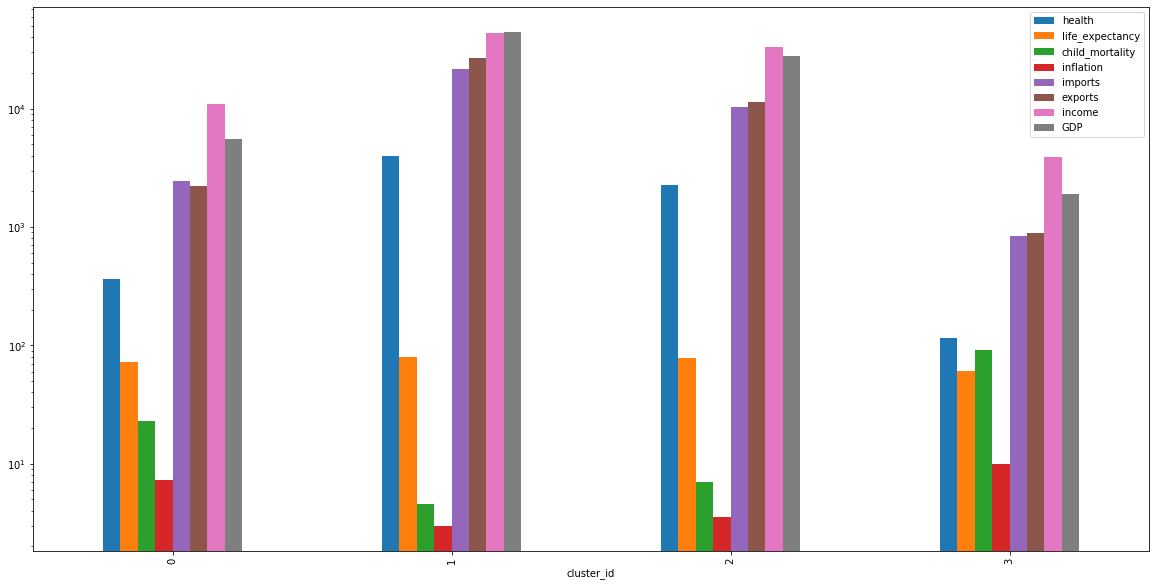

In [59]:
# cluster visualization based on socio-economic & health factors

profile = cluster_df[['cluster_id','health','life_expectancy','child_mortality','inflation','imports','exports','income','GDP']].groupby('cluster_id').mean()
profile.plot(kind='bar', figsize=(20,10))
plt.yscale('log')
plt.show()

### Conclusion
- For cluster 3, countries are having low income,gdp,health & child mortality is also high, thus making imbalances in the society.
- For all clusters life expectancy is approximately same for all countries.
- Countries in cluster 1 & 2 are better position as compared to other countries in terms of health,income,inflation rate & gdp.

In [60]:
# https://matplotlib.org/tutorials/introductory/pyplot.html
# https://medium.com/@The_Gambitier/matplotlib-essentials-e376ed954201

# Hierarchical Clustering

In [61]:
scaled_df.head()

,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP
0,1.291532,-0.668039,-0.629778,-0.733291,-0.958349,0.387667,-1.825310,2.020718,-0.757362
1,-0.538949,-0.542389,-0.473807,-0.472674,-0.394006,-0.404004,0.682454,-0.887331,-0.523321
2,-0.272833,-0.476048,-0.530344,-0.560668,-0.192552,1.452825,0.707406,-0.022587,-0.498838
3,2.007808,-0.419165,-0.589272,-0.543598,-0.667360,2.215708,-1.338729,2.049310,-0.560376
4,-0.695634,-0.027297,-0.150953,0.306143,0.227992,-0.891802,0.744836,-0.552591,0.013312


In [62]:
cluster_df.head()

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP,cluster_id
0,Afghanistan,90.2,70.4688,41.9174,248.297,1610.0,9.44,56.2,5.820,553,3
1,Albania,16.6,1145.2000,267.8950,1987.740,9930.0,4.49,76.3,1.650,4090,0
2,Algeria,27.3,1712.6400,185.9820,1400.440,12900.0,16.10,76.5,2.890,4460,0
3,Angola,119.0,2199.1900,100.6050,1514.370,5900.0,20.87,60.1,5.861,3530,3
4,Antigua and Barbuda,10.3,5551.0000,735.6600,7185.800,19100.0,1.44,76.8,2.130,12200,0


### Dendrogram formation using Single linkage & Complete linkage

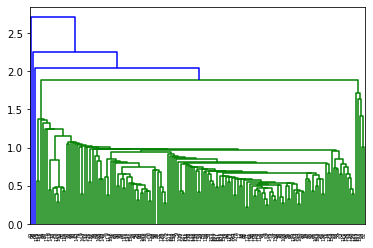

In [63]:
# single linkage

mergings = linkage(scaled_df, method='single', metric='euclidean')
dendrogram(mergings)
plt.show()

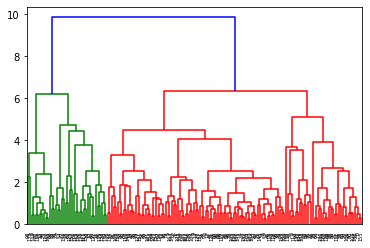

In [64]:
# complete linkage

mergings = linkage(scaled_df, method='complete', metric='euclidean')
dendrogram(mergings)
plt.show()

### Dendrogram cut to obtain clusters

In [65]:
# cutting the dendrogram at 4 to form 4 clusters

cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 2, 3, 1, 2, 2, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2,
       3, 1, 1, 1, 1, 0, 1, 1, 1, 3, 2, 0, 0, 1, 3, 0, 2, 1, 1, 0, 0, 1,
       0, 1, 3, 1, 1, 1, 0, 3, 2, 2, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1,
       0, 2, 1, 3, 1, 1, 0, 1, 1, 0, 3, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       3, 2, 0, 0, 3, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 0, 1, 1,
       0, 3, 2, 2, 1, 1, 2, 2, 1, 1, 0, 1, 3, 3, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [66]:
# assigning cluster labels

cluster_df['cluster_labels'] = cluster_labels
cluster_df.head()

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP,cluster_id,cluster_labels
0,Afghanistan,90.2,70.4688,41.9174,248.297,1610.0,9.44,56.2,5.820,553,3,0
1,Albania,16.6,1145.2000,267.8950,1987.740,9930.0,4.49,76.3,1.650,4090,0,1
2,Algeria,27.3,1712.6400,185.9820,1400.440,12900.0,16.10,76.5,2.890,4460,0,1
3,Angola,119.0,2199.1900,100.6050,1514.370,5900.0,20.87,60.1,5.861,3530,3,0
4,Antigua and Barbuda,10.3,5551.0000,735.6600,7185.800,19100.0,1.44,76.8,2.130,12200,0,1


### Cluster visualization

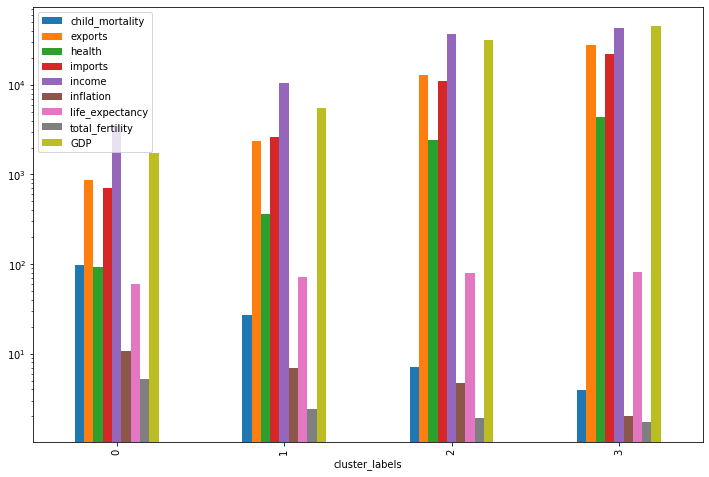

In [67]:
# visualization of clusters obtained, among the variable present in the dataframe

profile = cluster_df.drop('cluster_id', axis=1).groupby('cluster_labels').mean()
profile.plot(kind='bar', figsize=(12,8))
plt.yscale('log')
plt.show()

### cluster visualization in terms of income & child mortality

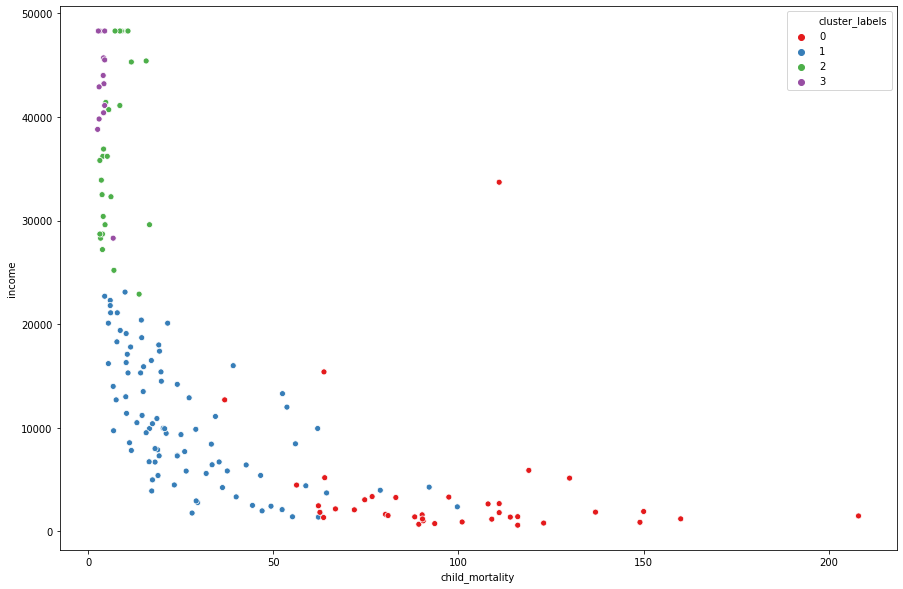

In [68]:
# plotting scatter plot of clusters obtained in hierarchical between variables income & child mortality

plt.figure(figsize=(15,10))
sns.scatterplot(x='child_mortality', y='income', data=cluster_df, hue='cluster_labels', palette='Set1')
plt.show()

### Cluster visualization in terms of GDP & child mortality

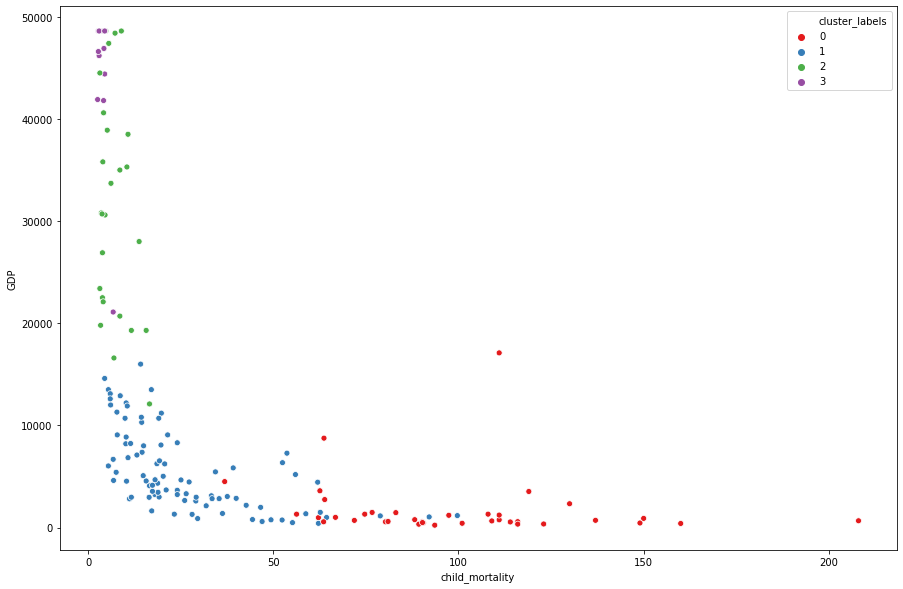

In [69]:
# # plotting scatter plot of cluster obtained in hierarchical between variables gdp & child mortality

plt.figure(figsize=(15,10))
sns.scatterplot(x='child_mortality', y='GDP', data=cluster_df, hue='cluster_labels', palette='Set1')
plt.show()

- From the above two graph between child mortality & income, gdp "cluster 0" is in urgent need of aid.

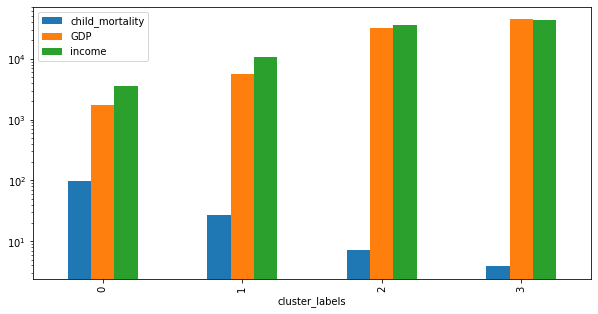

In [70]:
# cluster profiling interms of child mortality, cluster id, gdp, income

profile = cluster_df[['cluster_labels', 'child_mortality', 'GDP', 'income']].groupby('cluster_labels').mean()
profile.plot(kind='bar', figsize=(10,5))
plt.yscale('log')
plt.show()

In [71]:
# statistical description of the 4 clusters

profile = cluster_df[['cluster_labels', 'child_mortality', 'GDP', 'income']].groupby('cluster_labels').describe()
profile.transpose()

cluster_labels                    0             1             2             3
child_mortality count     38.000000     89.000000     26.000000     14.000000
                mean      98.847368     26.933708      7.050000      3.892857
                std       33.630197     19.930835      3.982788      1.112492
                min       36.900000      4.500000      3.200000      2.600000
                25%       75.200000     13.200000      3.925000      3.000000
                50%       92.050000     19.700000      5.400000      4.150000
                75%      115.500000     35.400000      8.900000      4.450000
                max      208.000000     99.700000     16.600000      6.800000
GDP             count     38.000000     89.000000     26.000000     14.000000
                mean    1731.500000   5513.674157  31466.153846  44940.714286
                std     3009.475430   3949.447981  10861.647049   7286.475844
                min      231.000000    413.000000  12100.000000  21100.000000
                25%      548.500000   2810.000000  22200.000000  44850.000000
                50%      733.000000   4540.000000  30750.000000  47755.000000
                75%     1310.000000   8080.000000  38800.000000  48610.000000
                max    17100.000000  16000.000000  48610.000000  48610.000000
income          count     38.000000     89.000000     26.000000     14.000000
                mean    3588.236842  10555.168539  36528.846154  43061.428571
                std     5849.873140   6108.423043   8188.232692   5412.333291
                min      609.000000   1390.000000  22900.000000  28300.000000
                25%     1252.500000   5600.000000  29600.000000  40575.000000
                50%     1835.000000   9860.000000  36000.000000  43600.000000
                75%     3225.000000  15400.000000  44325.000000  47642.500000
                max    33700.000000  23100.000000  48290.000000  48290.000000

### Hierarchical Clusters formed are described as below

- cluster 0 :- [High Child Mortality, Low(Income & GDP)]
- cluster 1 :- [Moderately High Child Mortality, Moderate Low(Income & GDP)]
- cluster 2 :- [Moderately Low Child Mortality, Moderate High(Income & GDP)]
- cluster 3 :- [Low Child Mortality, High(Income & GDP)]

### Data Inspection of formed clusters

In [72]:
# displaying the countries in the cluster 0
cluster_df[cluster_df['cluster_labels'] == 0].sort_values(by = ['child_mortality', 'income', 'GDP'], 
                                                          ascending = [False, True, True]).head(5)

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP,cluster_id,cluster_labels
66,Haiti,208.0,101.2860,45.74420,428.314,1500.0,5.45,55.78,3.330,662,3,0
132,Sierra Leone,160.0,70.4688,52.26900,169.281,1220.0,17.20,55.78,5.200,399,3,0
32,Chad,150.0,330.0960,40.63410,390.195,1930.0,6.39,56.50,5.861,897,3,0
31,Central African Republic,149.0,70.4688,26.71592,169.281,888.0,2.01,55.78,5.210,446,3,0
97,Mali,137.0,161.4240,35.25840,248.508,1870.0,4.37,59.50,5.861,708,3,0


In [73]:
# displaying the countries in the cluster 1
cluster_df[cluster_df['cluster_labels'] == 1].sort_values(by = ['child_mortality', 'income', 'GDP'], 
                                                          ascending = [False, True, True]).head(5)

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP,cluster_id,cluster_labels
87,Lesotho,99.7,460.9800,129.87000,1181.700,2380.0,4.15,55.78,3.30,1170,3,1
116,Pakistan,92.1,140.4000,26.71592,201.760,4280.0,10.90,65.30,3.85,1040,3,1
84,Lao,78.9,403.5600,50.95800,562.020,3980.0,9.20,63.80,3.15,1140,3,1
107,Myanmar,64.4,70.4688,26.71592,169.281,3720.0,7.04,66.80,2.41,988,0,1
81,Kiribati,62.7,198.1700,168.37000,1190.510,1730.0,1.52,60.70,3.84,1490,3,1


In [74]:
# displaying the countries in the cluster 2
cluster_df[cluster_df['cluster_labels'] == 2].sort_values(by = ['child_mortality', 'income', 'GDP'], 
                                                          ascending = [False, True, True]).head(5)

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP,cluster_id,cluster_labels
89,Libya,16.6,7937.6,469.48,5094.1,29600.0,14.2000,76.1,2.41,12100,0,2
128,Saudi Arabia,15.7,9572.8,827.97,6369.0,45400.0,17.2000,75.1,2.96,19300,2,2
10,Bahamas,13.8,9800.0,2209.20,12236.0,22900.0,0.1834,73.8,1.86,28000,2,2
115,Oman,11.7,12680.1,534.61,7951.6,45300.0,15.6000,76.1,2.90,19300,2,2
82,Kuwait,10.8,25679.5,1012.55,11704.0,48290.0,11.2000,78.2,2.21,38500,2,2


In [75]:
# displaying the countries in the cluster 3
cluster_df[cluster_df['cluster_labels']==3].sort_values(by=['child_mortality','income','GDP'],
                                                        ascending = [False, True, True]).head(5)

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP,cluster_id,cluster_labels
98,Malta,6.8,31385.1,1825.150,24241.56,28300.0,3.830,80.3,1.39,21100,1,3
15,Belgium,4.5,31385.1,4750.800,24241.56,41100.0,1.880,80.0,1.86,44400,1,3
110,Netherlands,4.5,31385.1,4966.701,24241.56,45500.0,0.848,80.7,1.79,48610,1,3
145,Switzerland,4.5,31385.1,4966.701,24241.56,48290.0,0.317,81.4,1.52,48610,1,3
8,Austria,4.3,24059.7,4966.701,22418.20,43200.0,0.873,80.5,1.44,46900,1,3


In [76]:
# five countries in urgent need of aid are from cluster 0

cluster_df[cluster_df['cluster_labels'] == 0].sort_values(by = ['child_mortality', 'income', 'GDP'], 
                                                          ascending = [False, True, True]).head(5)

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,GDP,cluster_id,cluster_labels
66,Haiti,208.0,101.2860,45.74420,428.314,1500.0,5.45,55.78,3.330,662,3,0
132,Sierra Leone,160.0,70.4688,52.26900,169.281,1220.0,17.20,55.78,5.200,399,3,0
32,Chad,150.0,330.0960,40.63410,390.195,1930.0,6.39,56.50,5.861,897,3,0
31,Central African Republic,149.0,70.4688,26.71592,169.281,888.0,2.01,55.78,5.210,446,3,0
97,Mali,137.0,161.4240,35.25840,248.508,1870.0,4.37,59.50,5.861,708,3,0


### Below 5 Countries are in urgent need of Aid of HELP International Humanitarian NGO
- Haiti
- Sierra Leone
- Chad
- Central African Republic
- Mali

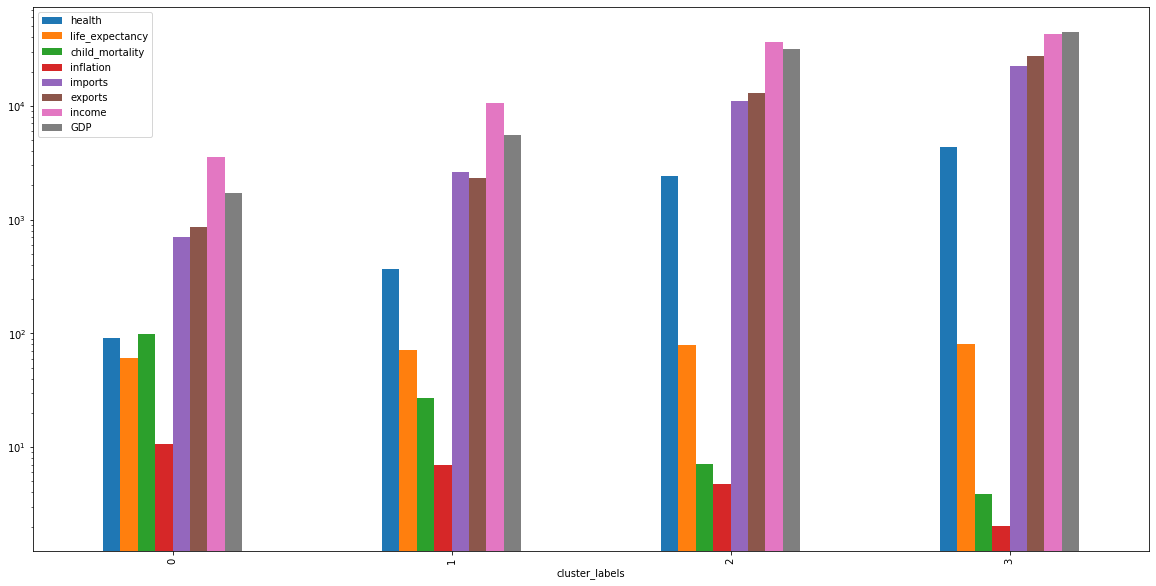

In [77]:
profile = cluster_df[['cluster_labels','health','life_expectancy','child_mortality','inflation','imports','exports','income','GDP']].groupby('cluster_labels').mean()
profile.plot(kind='bar', figsize=(20,10))
plt.yscale('log')
plt.show()

### Conclusion
- For cluster 0, countries are having low income,gdp,health & child mortality is also high, thus making imbalances in the society.
- For all clusters life expectancy is approximately same for all countries.
- Countries in cluster 2 & 3 are better position as compared to other countries in terms of health,income,inflation rate & gdp.